In [660]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.morphology as morph
import networkx as nx
import matplotlib.pyplot as plt

In [661]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [662]:
prueba1 = cv2.imread('database/15_gt.pgm', cv2.IMREAD_UNCHANGED)

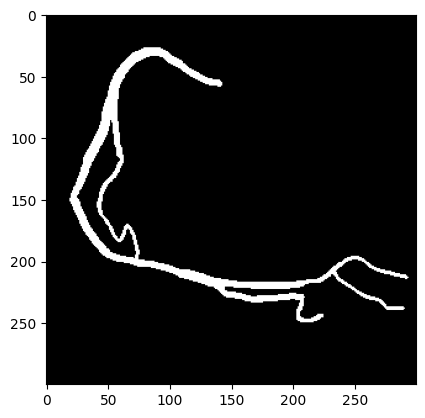

In [663]:
plot_image(prueba1)

In [664]:
def esqueletizar(imagen):
    return morph.skeletonize(imagen).astype(np.uint8)

In [665]:
def closing(imagen, kernel):
    return morph.closing(imagen, kernel)

In [666]:
def opening(imagen, kernel):
    return morph.opening(imagen, kernel)

In [667]:
def erosion(imagen, kernel):
    return morph.erosion(imagen, kernel)

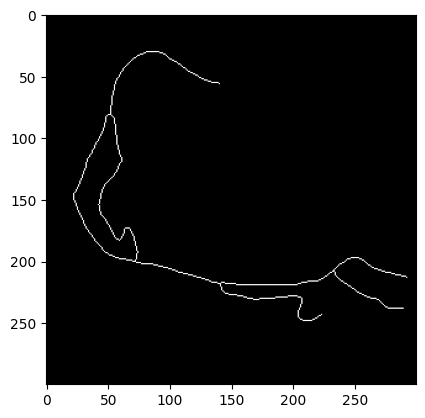

In [668]:
esqueleto = esqueletizar(prueba1)
plot_image(esqueleto)

In [669]:
graph = {}

In [670]:
class Node(object):
    x = 0
    y = 0

    def set_position(self, x, y):
        self.x = x
        self.y = y
        self.pos = (x, y)

    def get_position(self):
        return (self.x, self.y)

In [671]:
nodos = {}
G = nx.Graph()
first = True
raiz = None

In [672]:
def add_nodo(x, y):
    if (x, y) not in nodos:
        nodos[(x, y)] = Node()
        nodos[(x, y)].set_position(x, y)
        G.add_node((x, y), pos=(x, y))
    global first 
    global raiz
    if first:
        first = False
        raiz = (x, y)
        

In [673]:
def add_transition(x1, y1, x2, y2):
    add_nodo(x2, y2)
    G.add_edge((x1, y1), (x2, y2))

In [674]:
def check_neighbors(x, y, image):
    neighbors = []
    down = False
    up = False
    right = False
    left = False
    
    add_nodo(x, y)
    
    # left 
    if x > 0 and image[x-1, y] == 1:
        neighbors.append((x-1, y))
        left = True
        add_transition(x, y, x-1, y)
    # right
    if x < image.shape[0] - 1 and image[x+1, y] == 1:
        neighbors.append((x+1, y))
        right = True
        add_transition(x, y, x+1, y)
    # up
    if y > 0 and image[x, y-1] == 1:
        neighbors.append((x, y-1))
        up = True
        add_transition(x, y, x, y-1)
    # down
    if y < image.shape[1] - 1 and image[x, y+1] == 1:
        neighbors.append((x, y+1))
        down = True
        add_transition(x, y, x, y+1)
    # upper left
    if x > 0 and y > 0 and image[x-1, y-1] == 1 and not (up or left):
        neighbors.append((x-1, y-1))
        add_transition(x, y, x-1, y-1)
    # lower left
    if x > 0 and y < image.shape[1] - 1 and image[x-1, y+1] == 1 and not (down or left):
        neighbors.append((x-1, y+1))
        add_transition(x, y, x-1, y+1)
    # upper right
    if x < image.shape[0] - 1 and y > 0 and image[x+1, y-1] == 1 and not (up or right):
        neighbors.append((x+1, y-1))
        add_transition(x, y, x+1, y-1)
    # lower right
    if x < image.shape[0] - 1 and y < image.shape[1] - 1 and image[x+1, y+1] == 1 and not (down or right):
        neighbors.append((x+1, y+1))
        add_transition(x, y, x+1, y+1)
        
    return neighbors

In [675]:
def construct_graph(imagen):
    imagen = imagen.copy()
    bifurcation = []
    trifurcation = []
    end_points = []
    intemediate = []
    mod = 10
    cont = 0
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            if imagen[i][j] == 1:
                node = Node()
                node.set_position(i, j)
                graph[(i, j)] = node
                neighbors = check_neighbors(i, j, imagen)
                if len(neighbors) == 3:
                    bifurcation.append((i, j))
                if len(neighbors) == 4:
                    trifurcation.append((i, j))
                if len(neighbors) == 1:
                    end_points.append((i, j))
                if len(neighbors) == 2:
                    if i%15==0 or j%20==0:
                        intemediate.append([i, j])
            cont += 1 
    # intemediate = np.array(intemediate)
    # indices_ordenados = np.lexsort(intemediate.T)
    # intemediate = intemediate[indices_ordenados]
    # intemediate = intemediate.tolist()
    
    # eliminar = []
    # for i in range(len(intemediate) - 1):
    #     if i %mod != 0:
    #         eliminar.append(i)
        
    # intemediate = [i for j, i in enumerate(intemediate) if j not in eliminar]
    
    return graph, bifurcation, trifurcation, end_points, intemediate            

In [676]:
_, bifurcation, trifurcation, end_points, intermediate = construct_graph(esqueleto)

# Convertir arrays de NumPy a listas
bifurcation = np.unique(bifurcation, axis=0).tolist()
trifurcation = np.unique(trifurcation, axis=0).tolist()
end_points = np.unique(end_points, axis=0).tolist()

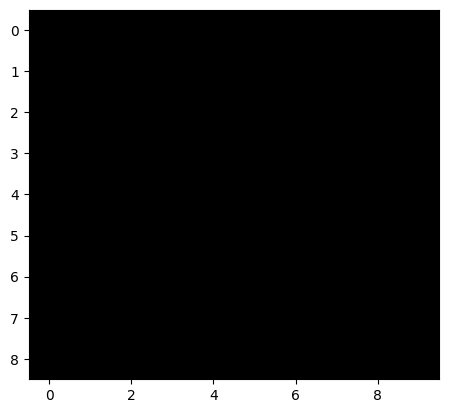

In [677]:
# temp = esqueleto[28:35, 160:170]
# temp = esqueleto[28:35, 160:170]
temp = esqueleto[41:50, 220:230]
# print(temp)
plot_image(temp)

In [678]:
def join_points(window_len,array):
    new_array = []
    elimimnar = []
    for element in array:
        matriz = [[0] * window_len for _ in range(window_len)]
        x, y = element
        for i in range(window_len):
            for j in range(window_len):
                matriz[i][j] = [x - window_len//2 + i,y - window_len//2 + j]
        for fila in matriz:
            for vecino in fila:
                if vecino in array and vecino != element:
                    avg = [(vecino[0] + x)//2, (vecino[1] + y)//2]
                    array.remove(vecino)
                    elimimnar.append(vecino)
                    if element not in elimimnar:
                        elimimnar.append(element)
                    new_array.append(avg)
                    
    for element in elimimnar:
        if element in array:
            array.remove(element)
            
    return array,new_array


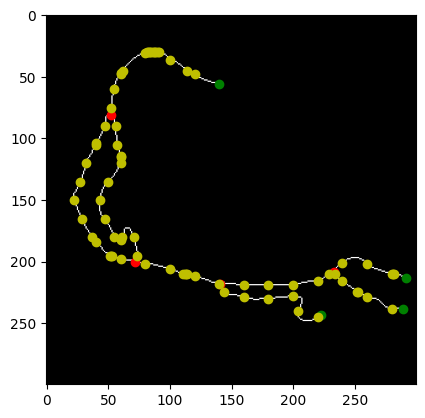

In [679]:
cuatrifurcation = []
ventana = 10
plt.imshow(esqueleto, cmap='gray')
bifurcation, new_trifurcation = join_points(ventana,bifurcation)
if len(new_trifurcation) > 0:
    if len(trifurcation) > 1:
        trifurcation.append(new_trifurcation)
    else:
        trifurcation.extend(new_trifurcation)


trifurcation, new_cuatrifurcation = join_points(ventana,trifurcation)
if len(new_cuatrifurcation) > 0:
    if len(cuatrifurcation) > 1:
        cuatrifurcation.append(new_cuatrifurcation)
    else:
        cuatrifurcation.extend(new_cuatrifurcation)

all_points = []
all_points.extend(bifurcation)
all_points.extend(trifurcation)
all_points.extend(end_points)
all_points.extend(intermediate)

x = [coord[1] for coord in bifurcation]
y = [coord[0] for coord in bifurcation]
plt.plot(x, y, 'ro')

x2 = [coord[1] for coord in trifurcation]
y2 = [coord[0] for coord in trifurcation]
plt.plot(x2, y2, 'bo')

x3 = [coord[1] for coord in end_points]
y3 = [coord[0] for coord in end_points]
plt.plot(x3, y3, 'go')

x4 = [coord[1] for coord in intermediate]
y4 = [coord[0] for coord in intermediate]
plt.plot(x4, y4, 'yo')



plt.show()

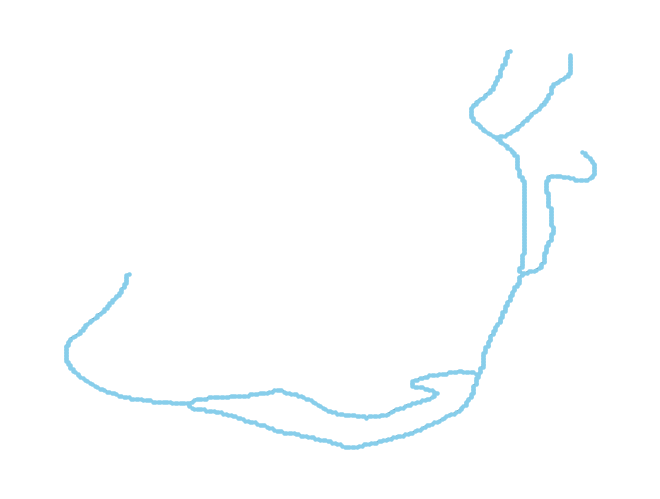

In [680]:
pos = nx.get_node_attributes(G, 'pos')
#pos = {nodo: nodo.get_position() for nodo in G.nodes()}
nx.draw(G, pos, with_labels=False, font_weight='bold', node_color='skyblue', font_color='black', node_size=5)
plt.show()

In [681]:
last_node = None
def dfs_custom(G, node, visited, edges, orientation='left'):
    global last_node, raiz
    
    node_t = [node[0], node[1]]
    if node_t in all_points:
        if last_node is not None:
            edges.append((last_node, node))
        last_node = node
    # Marcar el nodo como visitado
    if node not in visited:
        visited.add(node)
        
        if orientation == 'left':
            neighbours = sorted(list(G.neighbors(node)))
        else:
            neighbours = sorted(list(G.neighbors(node)), reverse=True)
            # neighbours.sort(reverse=True)
            

        # Recorrer todos los nodos adyacentes al nodo actual
        for neighbour in neighbours:
            if neighbour not in visited:
                dfs_custom(G, neighbour, visited, edges, orientation)
    
    if node_t in all_points:
        last_node = node

In [682]:
visited = set()
# highest_point = max(all_points, key=lambda x: x[0])
# raiz = tuple(highest_point)
edges = []
edges1 = []
dfs_custom(G, raiz, visited, edges)
visited = set()
dfs_custom(G, raiz, visited, edges1, orientation='right')
edges.extend(edges1)
if ((15, 120), (12, 103)) in edges:
    print('simon')

In [683]:
# visited = set()
# leftmost_point = min(all_points, key=lambda x: x[1])
# highest_point = max(all_points, key=lambda x: x[0])
# highest_point = tuple(highest_point)
# leftmost_point = tuple(leftmost_point)
# edges1 = []
# edges2 = []
# dfs_custom(G, highest_point, visited, edges1)
# dfs_custom(G, leftmost_point, visited, edges2)
# edges = edges1 + edges2

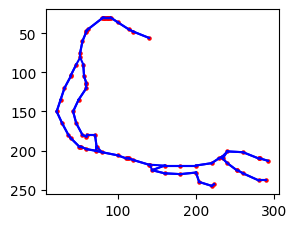

In [684]:
plt.figure(figsize=(3, 3), dpi=100)
for point in all_points:
    plt.scatter(point[1], point[0], color='red', s=5)

for arista in edges:
    plt.plot([arista[0][1], arista[1][1]], [arista[0][0], arista[1][0]], color='blue')
    
plt.gca().invert_yaxis()

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [22]:
bfs_order = list(nx.bfs_edges(G, raiz))
print("BFS Order:", bfs_order)

BFS Order: [((13, 90), (13, 91)), ((13, 90), (14, 89)), ((13, 91), (14, 92)), ((14, 89), (14, 88)), ((14, 92), (14, 93)), ((14, 88), (14, 87)), ((14, 93), (14, 94)), ((14, 87), (14, 86)), ((14, 94), (15, 95)), ((14, 86), (14, 85)), ((15, 95), (15, 96)), ((14, 85), (14, 84)), ((15, 96), (15, 97)), ((14, 84), (14, 83)), ((15, 97), (16, 98)), ((14, 83), (14, 82)), ((16, 98), (17, 99)), ((14, 82), (14, 81)), ((17, 99), (17, 100)), ((14, 81), (14, 80)), ((17, 100), (18, 101)), ((14, 80), (14, 79)), ((18, 101), (18, 102)), ((14, 79), (14, 78)), ((18, 102), (19, 103)), ((14, 78), (14, 77)), ((19, 103), (19, 104)), ((14, 77), (15, 76)), ((19, 104), (20, 105)), ((15, 76), (15, 75)), ((20, 105), (21, 106)), ((15, 75), (15, 74)), ((21, 106), (21, 107)), ((15, 74), (16, 73)), ((21, 107), (22, 108)), ((16, 73), (16, 72)), ((22, 108), (23, 109)), ((16, 72), (17, 71)), ((23, 109), (24, 110)), ((17, 71), (17, 70)), ((24, 110), (24, 111)), ((17, 70), (18, 69)), ((24, 111), (24, 112)), ((18, 69), (18, 6

In [23]:
result = bifurcation + trifurcation + end_points + intermediate

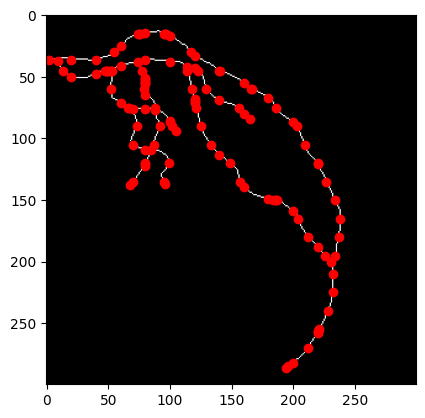

In [24]:
x = [coord[1] for coord in result]
y = [coord[0] for coord in result]
plt.plot(x, y, 'ro')
plt.imshow(esqueleto, cmap='gray')
plt.show()

In [25]:
def Generate_data(ruta):
    imagen_groundtruth = cv2.imread(ruta, cv2.IMREAD_UNCHANGED)
    esqueleto = esqueletizar(imagen_groundtruth)
    
    plt.figure(figsize=(10, 5))

    # Subgráfico 1 (1 fila, 2 columnas, primer subgráfico)
    plt.subplot(1, 2, 1)
    plt.imshow(imagen_groundtruth, cmap='gray')
    plt.title('Groundtruth image')
    
    _, bifurcation, trifurcation, end_points, intermediate = construct_graph(esqueleto)

    # Convertir arrays de NumPy a listas
    bifurcation = np.unique(bifurcation, axis=0).tolist()
    trifurcation = np.unique(trifurcation, axis=0).tolist()
    end_points = np.unique(end_points, axis=0).tolist()
    
    cuatrifurcation = []
    ventana = 10
    bifurcation, new_trifurcation = join_points(ventana,bifurcation)
    if len(new_trifurcation) > 0:
        if len(trifurcation) > 1:
            trifurcation.append(new_trifurcation)
        else:
            trifurcation.extend(new_trifurcation)


    trifurcation, new_cuatrifurcation = join_points(ventana,trifurcation)
    if len(new_cuatrifurcation) > 0:
        if len(cuatrifurcation) > 1:
            cuatrifurcation.append(new_cuatrifurcation)
        else:
            cuatrifurcation.extend(new_cuatrifurcation)

    plt.subplot(1, 2, 2)
    plt.imshow(esqueleto, cmap='gray')
    plt.title('Graph image')
    
    x4 = [coord[1] for coord in intermediate]
    y4 = [coord[0] for coord in intermediate]
    plt.plot(x4, y4, 'yo')

    x = [coord[1] for coord in bifurcation]
    y = [coord[0] for coord in bifurcation]
    plt.plot(x, y, 'ro')

    x2 = [coord[1] for coord in trifurcation]
    y2 = [coord[0] for coord in trifurcation]
    plt.plot(x2, y2, 'bo')

    x3 = [coord[1] for coord in end_points]
    y3 = [coord[0] for coord in end_points]
    plt.plot(x3, y3, 'go')

    plt.tight_layout()

    # Guardar la figura en un archivo (por ejemplo, PNG)
    plt.savefig('Imagenes_resultados/'+ruta[9:]+'.png')
    plt.show()
    
    nodos = bifurcation + trifurcation + end_points + intermediate
    
    Json_text = '{"nodos":'+str(nodos)+',\n"extremos":'+str(end_points)+',\n"bifurcaciones":'+str(bifurcation)+',\n"trifurcaciones":'+str(trifurcation)+',\n"intermedios":'+str(intermediate)+',\n"cuatrifurcaciones":'+str(cuatrifurcation)+'\n}'
    #Escribir el archivo JSON
    with open('Grafo_resultado/'+ruta[9:]+'.json', 'w') as file:
        file.write(Json_text)


    

In [27]:
# import os
# import re

# # Ruta de la carpeta
# ruta_carpeta = 'database'

# # Listar solo los archivos en la carpeta
# archivos_en_carpeta = [archivo for archivo in os.listdir(ruta_carpeta) if os.path.isfile(os.path.join(ruta_carpeta, archivo))]

# # Aplicar filtro con regex para incluir solo los archivos que contienen "_gt"
# archivos_filtrados = [archivo for archivo in archivos_en_carpeta if re.search(r'_gt', archivo)]

# # Mostrar los nombres de los archivos filtrados
# archivos_filtrados.sort()

# for archivo in archivos_filtrados:
#     ruta = ruta_carpeta + '/' + archivo
#     Generate_data(ruta)
